In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer

In [2]:
data = pd.read_csv("bank_marketing/bank/bank-full.csv", sep = ';')


pd.set_option('future.no_silent_downcasting', True)
data['y']= data['y'].replace({'yes':1, 'no': 0})

In [3]:
# Identify categorical columns in DataFrame

X= data.drop(columns=['y']) # Independent variables
y= data['y'] # target variable
y=y.astype(int)

In [4]:
# Split 60% for training and 40% for val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split 20% for validation and 20% for testing from the remaining 40%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Print shapes of resulting splits to check
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (27126, 16) (27126,)
Validation set size: (9042, 16) (9042,)
Test set size: (9043, 16) (9043,)


In [5]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns

# One-Hot Encode the categorical variables in the training and validation sets

encoder = OneHotEncoder(drop='first', sparse_output=False)  # to avoid multicollinearity

# Fit the encoder on the training data and transform both train and validation sets
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_cols]))

# Reset index to ensure alignment of rows after one-hot encoding
X_train_encoded.index = X_train.index
X_val_encoded.index = X_val.index

# Drop the original categorical columns and concatenate the one-hot encoded columns
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
X_val_final = pd.concat([X_val.drop(columns=categorical_cols), X_val_encoded], axis=1)
X_train_final.columns = X_train_final.columns.astype(str)
X_val_final.columns = X_val_final.columns.astype(str)

In [6]:
# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [7]:
# # Predict on the validation dataset
# y_val_pred = model.predict(X_val_final)

# # Calculate the accuracy and round it to 2 decimal places
# accuracy = accuracy_score(y_val, y_val_pred)
# accuracy = round(accuracy, 2)

# # Display the accuracy
# print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9


In [11]:
# Question 1: ROC AUC feature importance. Highest feature AUC
# Answer: `duration`

numerical_cols = X_train_final.select_dtypes(include=['float64', 'int64']).columns

# Store AUC scores
auc_scores = {}

# Calculate AUC for each numerical variable
for col in numerical_cols:
    # Calculate AUC score
    auc = roc_auc_score(y_train, X_train_final[col])
    
    # Store AUC score
    auc_scores[col] = auc
    
    # Check if AUC is less than 0.5 and invert if necessary
    if auc < 0.5:
        X_train_final[col] = -X_train_final[col]  # Invert the variable
        auc_scores[col] = roc_auc_score(y_train, X_train_final[col])
        
# Display AUC scores
auc_scores_rounded = {k: round(v, 3) for k, v in auc_scores.items()}
print("AUC Scores for Numerical Variables:")
for col, score in auc_scores_rounded.items():
    print(f"{col}: AUC = {score}")

AUC Scores for Numerical Variables:
age: AUC = 0.503
balance: AUC = 0.587
day: AUC = 0.523
duration: AUC = 0.807
campaign: AUC = 0.57
pdays: AUC = 0.595
previous: AUC = 0.604
0: AUC = 0.544
1: AUC = 0.505
2: AUC = 0.504
3: AUC = 0.519
4: AUC = 0.527
5: AUC = 0.501
6: AUC = 0.512
7: AUC = 0.516
8: AUC = 0.506
9: AUC = 0.506
10: AUC = 0.501
11: AUC = 0.548
12: AUC = 0.544
13: AUC = 0.528
14: AUC = 0.547
15: AUC = 0.503
16: AUC = 0.505
17: AUC = 0.606
18: AUC = 0.538
19: AUC = 0.508
20: AUC = 0.608
21: AUC = 0.505
22: AUC = 0.508
23: AUC = 0.513
24: AUC = 0.502
25: AUC = 0.52
26: AUC = 0.512
27: AUC = 0.519
28: AUC = 0.571
29: AUC = 0.507
30: AUC = 0.527
31: AUC = 0.521
32: AUC = 0.51
33: AUC = 0.585
34: AUC = 0.602


In [14]:
# Question 2. Validation AUC 
# Answer:

# Convert DataFrame to dictionary format for DictVectorizer
data_dicts = X.to_dict(orient='records')

# Apply DictVectorizer to one-hot encode categorical variables
vectorizer = DictVectorizer(sparse=False)
X_encoded = vectorizer.fit_transform(data_dicts)

# Split the data into train/val/test sets (60%/20%/20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
# Make predictions on the validation set
y_val_probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class


# Calculate AUC score
auc_score = roc_auc_score(y_val, y_val_probs)
print(f"AUC Score: {round(auc_score, 3)}")

AUC Score: 0.907


/Users/jessbryte/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


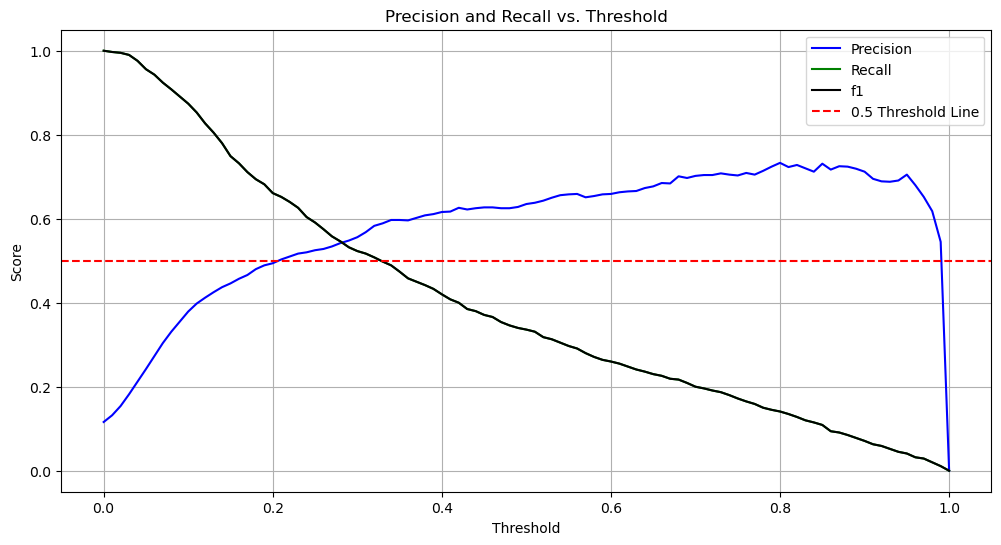

     Threshold  Precision  Recall  F1 Score
0         0.00      0.116   1.000     0.208
1         0.01      0.132   0.997     0.233
2         0.02      0.154   0.995     0.267
3         0.03      0.182   0.990     0.307
4         0.04      0.212   0.976     0.349
..         ...        ...     ...       ...
96        0.96      0.680   0.032     0.062
97        0.97      0.652   0.029     0.055
98        0.98      0.618   0.020     0.039
99        0.99      0.545   0.011     0.022
100       1.00      0.000   0.000     0.000

[101 rows x 4 columns]


In [22]:
# Question 3. Precision and recall


# Define thresholds to evaluate precision and recall
thresholds = np.arange(0.0, 1.01, 0.01)  # From 0.0 to 1.0 with a step of 0.01

# Store metrics for each threshold
precision_list = []
recall_list = []
f1_list = []

# Calculate precision, recall, and F1 score for each threshold
for threshold in thresholds:
    y_val_pred = (y_val_probs >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    # Append metrics to the lists
    precision_list.append(round(precision, 3))
    recall_list.append(round(recall, 3))
    f1_list.append(round(f1, 3))

# Plot Precision and Recall
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='green')
plt.plot(thresholds, recall_list, label='f1', color='black')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axhline(y=0.5, color='r', linestyle='--', label='0.5 Threshold Line')  # Optional threshold line
plt.legend()
plt.grid()
plt.show()

# Display F1 scores for each threshold
f1_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

print(f1_df[['Threshold', 'Precision', 'Recall', 'F1 Score']])

In [ ]:
# Question 4. F1 score threshold